<a href="https://colab.research.google.com/github/awr7/Machine-Learning-Algorithms/blob/main/Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

*   By: Angel Rosario

# About This Project

This project explores image classification using Convolutional Neural Networks (CNNs) on the FashionMNIST dataset, an advanced alternative to the traditional MNIST dataset of handwritten digits. FashionMNIST comprises grayscale images of various fashion products, providing a more challenging and realistic dataset for machine learning models. The core objective is to modify and enhance a pre-existing CNN to achieve an accuracy of over 90% on this dataset, demonstrating the model's adaptability and efficiency in recognizing complex patterns in fashion item images. Key adjustments in the network include fine-tuning kernel sizes, channel numbers, and fully connected layer features, alongside optimizing the learning rate and batch size. Additionally, the project investigates the impact of computational resources by comparing the model's training time on GPU versus CPU, offering practical insights into the effectiveness of hardware acceleration in deep learning.


---
The first thing I did was to lower the kernel to 3 since most useful feautures of a image are mostly local so is better to take few local pixels at a time to apply convolutions. I then increased the number of channels in order to get better feauture extraction in the conv layers and since I had more channels I increased the number of feautures in the fully connected layers. Next I changed the optimizer by decreasing the learning rate and batch size to update the model more frequently but also taking smaler steps towards the minimun by decreasing the learning rate so it doesn't get stuck in a local minima. When I changed use_gpu to True I found that on average the runtime of each epoch was around 9 seconds while when I had use_gpu set to False on average the runtime of each epoch was around 22 seconds. When changing to the original MNIST dataset I found that my model worked really well as I was able to get accuracy of around 98%. I believe that my model works well for both datasets because both data sets are gray scale and both are of the same size of 28x28 pixels with the same distribution of 10 classes each so my model doesn't need to be changed in any way in order to efficiently predict both datasets.

---
# CNN for FashionMNIST Image Classification




Examples based on the DeepLizard Tutorial: http://deeplizard.com/learn/video/v5cngxo4mIg

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Section 1: Data and Data Processing

Importance of Data in Deep Learning - http://deeplizard.com/learn/video/EqpzfvxBx30  
Extract, Transform, Load (ETL) - http://deeplizard.com/learn/video/8n-TGaBZnk4  
PyTorch Datasets and DataLoaders - http://deeplizard.com/learn/video/mUueSPmcOBc  

In [2]:
# adapt the learning_rate
learning_rate = 0.01

# adapt the batch_size
batch_size = 100

# check performance without use_gpu
use_gpu = True

num_epochs = 5

In [3]:
train_set = torchvision.datasets.FashionMNIST(
#train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 12321304.37it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211507.44it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3917037.80it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10213943.70it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



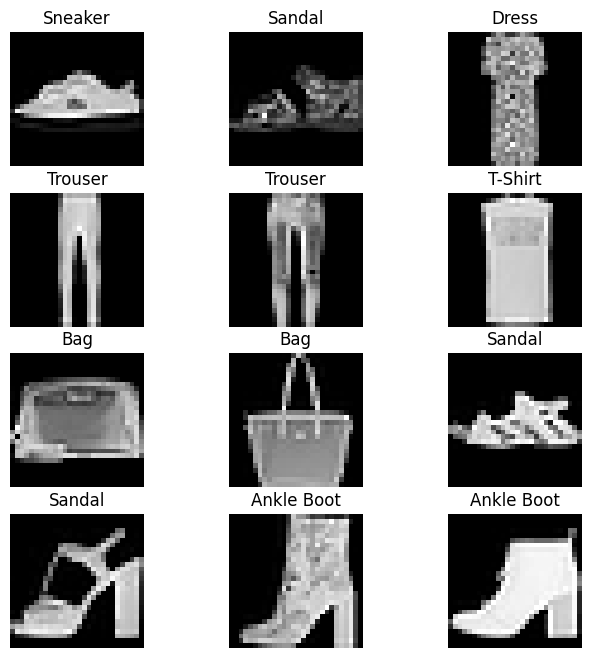

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Feature batch shape: torch.Size([100, 1, 28, 28])
Labels batch shape: torch.Size([100])


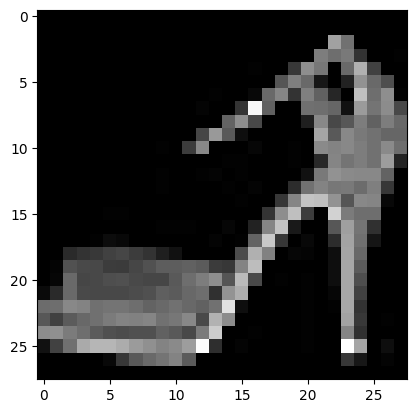

Label: 5


In [5]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# Section 2: Neural Networks and PyTorch Design

Build PyTorch CNN - http://deeplizard.com/learn/video/k4jY9L8H89U  
CNN Layers - http://deeplizard.com/learn/video/IKOHHItzukk  
CNN Weights - http://deeplizard.com/learn/video/stWU37L91Yc  
Callable Neural Networks - http://deeplizard.com/learn/video/rcc86nXKwkw  
CNN Forward Method - http://deeplizard.com/learn/video/MasG7tZj-hw  

In [6]:
class Network_FashionMNIST(nn.Module):
    def __init__(self):
        super(Network_FashionMNIST, self).__init__()

        # adapt the kernel sizes
        # adapt the number of channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)

        # adapt the number of feautres
        self.fc1 = nn.Linear(in_features=32*5*5, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=10)

    def forward(self, t):
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.view(t.size(0), -1)
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)

        return t

    # this is a copy of forward used to print the size of the layers
    def print_forward(self, t):
        # (1) input layer
        t = t
        print("(1) input layer: ", t.size())

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        print("(2) hidden conv layer: ", t.size())

        t = F.max_pool2d(t, kernel_size=2, stride=2)
        print("(2) max pool filter: ", t.size())

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        print("(3) hidden conv layer: ", t.size())

        t = F.max_pool2d(t, kernel_size=2, stride=2)
        print("(3) max pool filter: ", t.size())

        # (4) hidden linear layer
        t = t.view(t.size(0), -1)
        t = self.fc1(t)
        t = F.relu(t)
        print("(4) hidden linear layer: ", t.size())

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)
        print("(5) hidden linear layer: ", t.size())

        # (6) output layer
        t = self.out(t)
        print("(6) output layer: ", t.size())
        #t = F.softmax(t, dim=1)

        return t

# Section 3: Training Neural Networks

In [7]:
# create instance of the network
network = Network_FashionMNIST()

# print network setup
print(network)

# run the print forward pass to see the sizes of layers
x = torch.randn(1, 1, 28, 28)
network.cpu().print_forward(x);

Network_FashionMNIST(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=10, bias=True)
)
(1) input layer:  torch.Size([1, 1, 28, 28])
(2) hidden conv layer:  torch.Size([1, 16, 26, 26])
(2) max pool filter:  torch.Size([1, 16, 13, 13])
(3) hidden conv layer:  torch.Size([1, 32, 11, 11])
(3) max pool filter:  torch.Size([1, 32, 5, 5])
(4) hidden linear layer:  torch.Size([1, 128])
(5) hidden linear layer:  torch.Size([1, 32])
(6) output layer:  torch.Size([1, 10])


In [8]:
# create optimizer, we use the SGD which we learned
optimizer = optim.SGD(network.parameters(), lr=learning_rate) # Optimizer

# creat a device, gpu if requested
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
# print("used device:", device)

# move the network to the device
network = network.to(device)

# array to store the progress
epoch_loss = []

In [ ]:
# The training loop
for epoch in range(num_epochs):
    t = time.time()
    total_labels = 0
    total_correct = 0
    total_loss = 0
    epoch_loss.append(0)

    for batch in train_loader:
        # get the samples images and their labels for the batk
        images, labels = batch

        # move to selected device (gpu or cpu)
        images = images.to(device)
        labels = labels.to(device)

        # class predictions
        preds = network(images)

        # cross-entropy loss
        loss = F.cross_entropy(preds, labels)

        # clear gradient
        optimizer.zero_grad()
        # backpropagation
        loss.backward()

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        # track loss and predicion accuracy
        epoch_loss[-1] += loss.item()
        total_loss += loss.item()
        total_correct += preds.argmax(dim=1).eq(labels).sum().item()
        total_labels += len(labels)

    print('Epoch [%d / %d] loss: %f, accuracy: %f, time: %3.3f'
          % (epoch+1, num_epochs, total_loss, total_correct/total_labels, np.round_(time.time() - t, 3)))

Epoch [1 / 5] loss: 80.513481, accuracy: 0.949767, time: 9.768
Epoch [2 / 5] loss: 79.642579, accuracy: 0.950333, time: 9.765
Epoch [3 / 5] loss: 79.320683, accuracy: 0.950850, time: 9.813
Epoch [4 / 5] loss: 77.790789, accuracy: 0.951533, time: 9.787
Epoch [5 / 5] loss: 77.826912, accuracy: 0.952117, time: 8.992


Plot Training Curve
--------------------

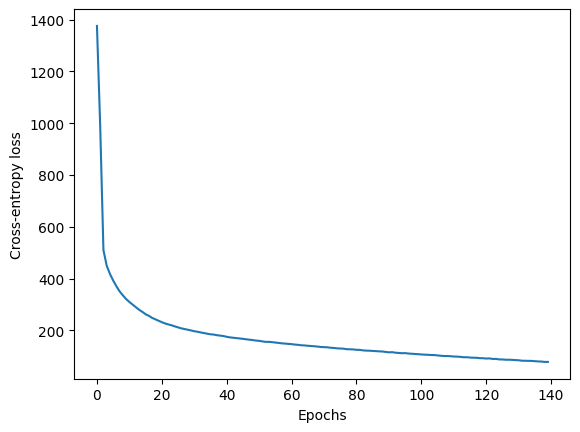

In [ ]:
# plot the loss per epoch curve
fig = plt.figure()
plt.plot(epoch_loss)
plt.xlabel('Epochs')
plt.ylabel('Cross-entropy loss')
plt.show()

In [ ]:
# Function to get all predictions at once
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    for batch in loader:
        # get the samples images and their labels for the batk
        images, labels = batch

        # move to selected device (gpu or cpu)
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

In [ ]:
# Analytics
prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)

# turn off gradient for forward evaluation
with torch.no_grad():
    train_preds = get_all_preds(network, prediction_loader)
    preds_correct = train_preds.argmax(dim=1).eq(train_set.targets.to(device)).sum().item()

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(train_set))

total correct: 57399
accuracy: 0.95665


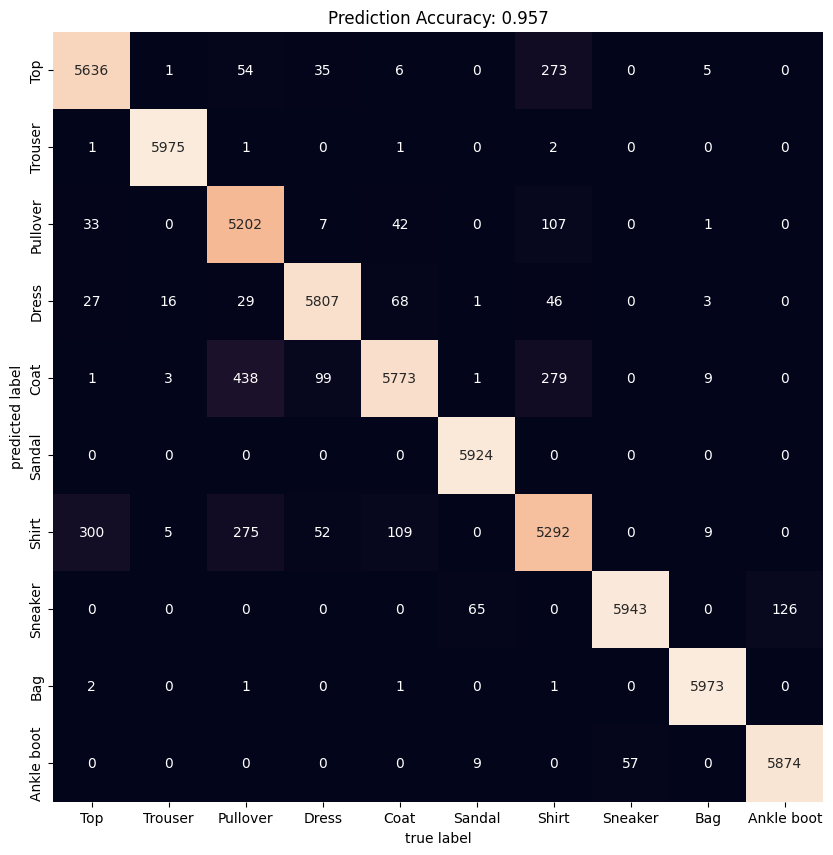

In [ ]:
# move data to cpu for using scikit
targets_cpu = train_set.targets.cpu()
preds_cpu = train_preds.cpu()

# compute the confusion matrix
cm = confusion_matrix(targets_cpu, preds_cpu.argmax(dim=1))
labels_names = ('Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot')

# plot the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("Prediction Accuracy: %1.3f" %accuracy_score(targets_cpu, preds_cpu.argmax(dim=1)));